# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 37

**Author 1 (sciper):** Elias De Smijter (366670)  
**Author 2 (sciper):** Félicie Alice Agnès Marie Giraud-Sauveur (284220)   
**Author 3 (sciper):** Cyril Felix Monette (299554)   

**Release date:** 8.03.2023  
**Due date:** 24.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data') # os.path.join('data')
print(data_base_path)
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

../data


---
## Part 1: Segmentation


### 1.0 Intro

In this exercise, you will be given two images. 

* `mucinous_adeno.jpg`: The image depicts a tissue sample from mucinous adenocarcinoma in colorectal cancer. The data is taken from the Cancer Genome Atlas (TCGA) which is an open-source database of different cancer types. Here you can see a tissue taken from a patient and stained using hematoxylin (purple) and eosin (pink) staining. The hematoxylin stains cell nuclei with a purplish blue, and the eosin stains the extracellular matrix and cytoplasm in pink.

* `mucinous_adeno_gt.jpg`: The second image is a coarse annotation of what is regarded as the so-called mucinous area. The mucinous area can be identified as a gray area tainted with purple. The presence of a large amount of mucin is a sign of a defect of normal epithelial cells that start to produce an unreasonable amount of mucin.


### 1.1 Tasks

You will be asked to extract the mucinous area using various approaches:

- [ ] Thresholding
- [ ] Morphology
- [ ] Region growing


### 1.1 Brain image visualization

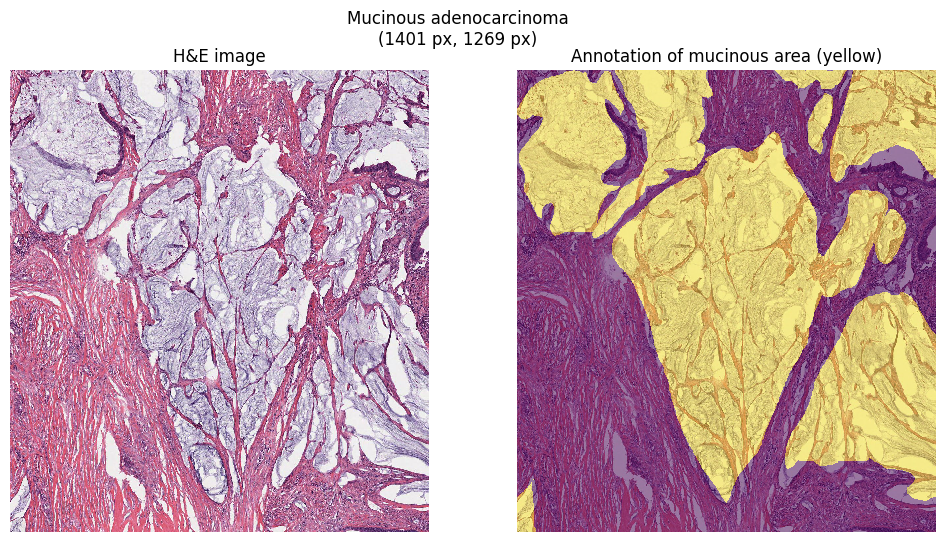

In [22]:
import skimage.io
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

# Load images
path_to_image = os.path.join(data_base_path, data_folder, "mucinous_adeno.jpg")
path_to_gt = os.path.join(data_base_path, data_folder, "mucinous_adeno_gt.jpg")
adeno_img = skimage.io.imread(path_to_image)
adeno_gt = skimage.io.imread(path_to_gt) > 128

# Get size of the image in px
im_h, im_w, im_c = adeno_img.shape

# Display MRI image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image')
ax[0].axis('off')

# Plot image with overlay
ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')
plt.suptitle("Mucinous adenocarcinoma\n({} px, {} px)".format(im_h, im_w))
plt.show()

---
### 1.2 Thresholding (4pts)
#### 1.2.1 RGB & Hue (1 pts)

Display the histogram for each channel (R, G, and B) as well as the histogram for the H (hue) channel. Note that you can use [rgb2hsv](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2hsv) to convert an RGB image to an HSV image and then extract the hue.

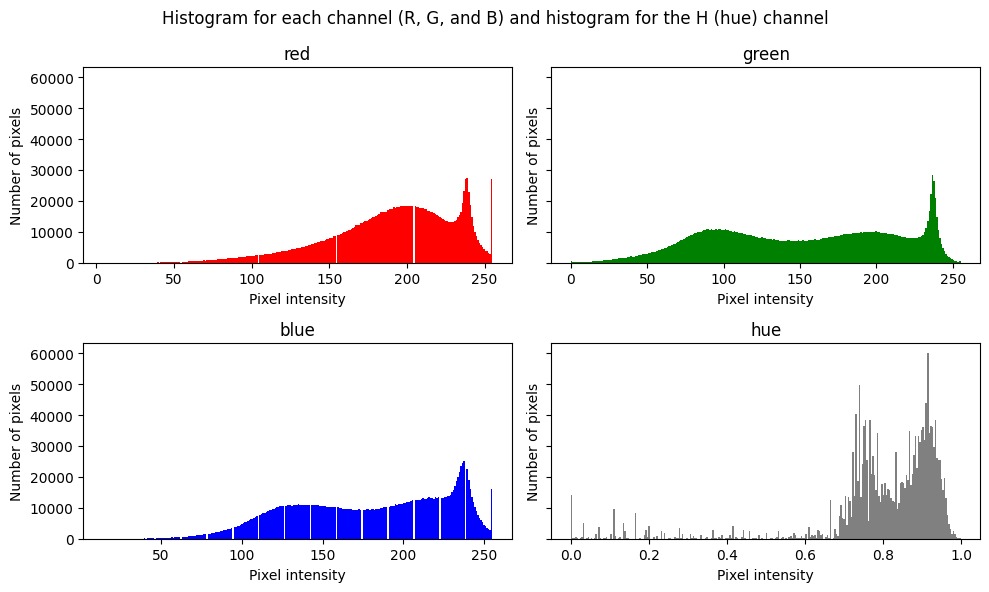

In [23]:
import cv2 as cv

# adeno_img_hsv=skimage.color.rgb2hsv(adeno_img)
adeno_img_hsv=cv.cvtColor(adeno_img, cv.COLOR_RGB2HSV)

from skimage import color

fig, axs = plt.subplots(2, 2, sharey=True, figsize=(10, 6))
axs = axs.flatten()

for ax, c in zip(axs, [(0, 'red'), (1, 'green'), (2, 'blue'), (0, 'hue')]):
    if c[1] != 'hue':
        ax.hist(adeno_img[:,:,c[0]].ravel(), bins=256, color = c[1])
        ax.title.set_text(c[1])
        ax.set_xlabel('Pixel intensity')
        ax.set_ylabel('Number of pixels')
    else:
        ax.hist(color.rgb2hsv(adeno_img)[:,:,c[0]].ravel(), bins=256, color = 'gray')
        ax.title.set_text(c[1])
        ax.set_xlabel('Pixel intensity')
        ax.set_ylabel('Number of pixels')
    
fig.suptitle("Histogram for each channel (R, G, and B) and histogram for the H (hue) channel")
plt.tight_layout()
plt.show()

#### 1.2.2 Apply Thresholding (2 pts)

For each histogram find the threshold(s) that work the best to isolate the mucinous area. Display the image after thresholding of each channel as well as the error between your prediction ($im$) and the annotations ($gt$) using the formula:

$$error = 1 - \left( \frac{1}{IJ} \sum_{i,j} im_{i,j} == gt_{i, j} \right)$$

Here, I and J are the dimension of the image.

red:
The error is 0.45 and the threshold is 181.0.
............
green:
The error is 0.26 and the threshold is 150.0.
............
blue:
The error is 0.27 and the threshold is 175.0.
............
hue:
The error is 0.49 and the threshold is 92.0.
............


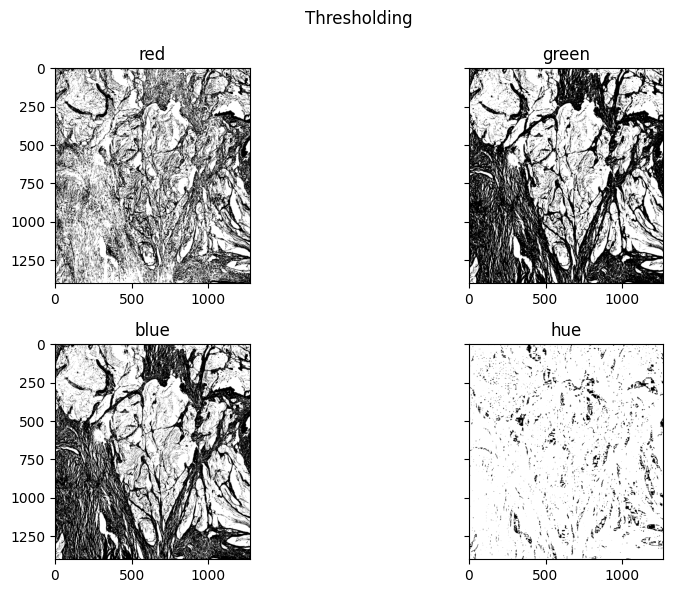

In [24]:
def error(im, gt):
    I, J = im.shape[0], im.shape[1]
    error = 1 - ((im == np.where(gt==False, 0, 255)).sum() / (I*J))
    return error

fig, axs = plt.subplots(2, 2, sharey=True, figsize=(10, 6))
axs = axs.flatten()

for ax, c in zip(axs, [(0, 'red'), (1, 'green'), (2, 'blue'), (0, 'hue')]):
    print(c[1]+':')
    if c[1] != 'hue':
        ret, th = cv.threshold(adeno_img[:,:,c[0]], 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    else:
        ret, th = cv.threshold(adeno_img_hsv[:,:,c[0]], 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    print('The error is {} and the threshold is {}.'.format(round(error(th, adeno_gt), 2), ret))
    print('............')
    ax.imshow(th, cmap='gray')
    ax.title.set_text(c[1])
          
fig.suptitle("Thresholding")
plt.tight_layout()
plt.show()

#### 1.2.3 Best Thresholding (1 pts)

Based on your previous findings, set the best threshold(s) and create the final mask as the variable `mask_thesholding`

In [25]:
# TODO: replace variable with your own threshod
mask_thesholding = np.zeros_like(adeno_gt)
# Green thresholding:
ret, th = cv.threshold(adeno_img[:,:,1], 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
mask_thesholding[th[:,:]>0]=1

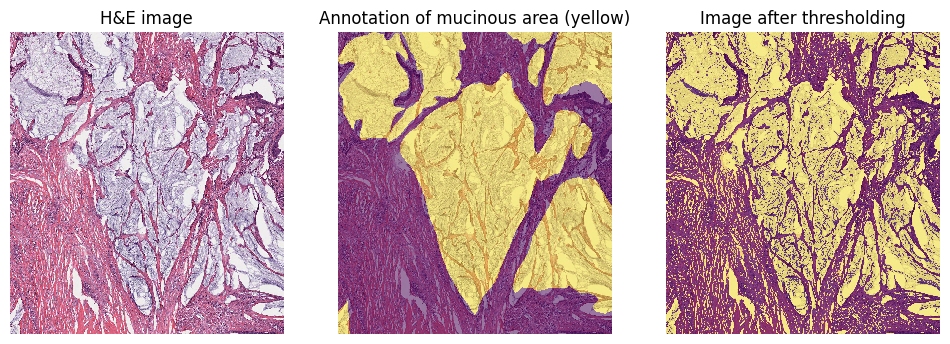

In [26]:
# Display MRI image
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')

ax[2].imshow(adeno_img, interpolation='nearest')
ax[2].imshow(mask_thesholding, alpha=0.5, interpolation='nearest')
ax[2].set_title('Image after thresholding')
ax[2].axis('off')

plt.show()

---

### 1.3 Morphology (5pts)

To proceed, use the best results of the previous model (namely `mask_thesholding`) as the starting point. In this exercise we will try to clean the mask using morphology.

* A (2pts): Try the following operation [closing](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.closing), [opening](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.opening) with [disk](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk) size of: $1, 2, 5, 10$. Comment on the quality of the results.

* B (2pts): Try the following operation [remove_small_holes](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_holes), [remove_small_objects](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects) with size of: $10, 50, 100, 500$. Comment on the quality of the results.

* C (1pts): Based on your previous results, can you find a combination of the functions that improve your results? Plot the best result along with the error rate. Save the mask as the variable `mask_morph`

/Users/eliasdesmijter/miniconda3/envs/EE490/lib/python3.8/site-packages/skimage/_shared/utils.py:274: FutureWarning: `selem` is a deprecated argument name for `closing`. It will be removed in version 1.0. Please use `footprint` instead.
  warnings.warn(self.warning_msg.format(


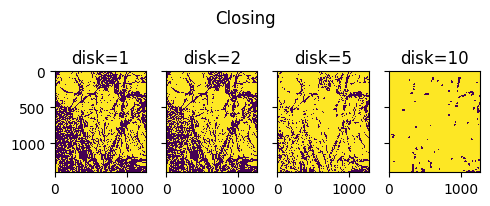

/Users/eliasdesmijter/miniconda3/envs/EE490/lib/python3.8/site-packages/skimage/_shared/utils.py:274: FutureWarning: `selem` is a deprecated argument name for `opening`. It will be removed in version 1.0. Please use `footprint` instead.
  warnings.warn(self.warning_msg.format(


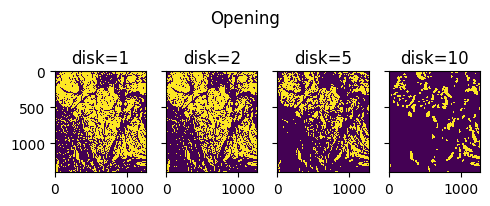

In [27]:
# Question A
from skimage.morphology import closing, opening, disk

## Closing 

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(5, 2))
axs = axs.flatten()

for ax, d in zip(axs, [1, 2, 5, 10]): 
    mask_closing = closing(mask_thesholding, selem=disk(d))
    ax.imshow(mask_closing, interpolation='nearest')
    ax.title.set_text('disk='+str(d))
    
fig.suptitle("Closing")
plt.tight_layout()
plt.show()


## Opening

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(5, 2))
axs = axs.flatten()

for ax, d in zip(axs, [1, 2, 5, 10]): 
    mask_opening = opening(mask_thesholding, selem=disk(d))
    ax.imshow(mask_opening, interpolation='nearest')
    ax.title.set_text('disk='+str(d))
    
fig.suptitle("Opening")
plt.tight_layout()
plt.show()

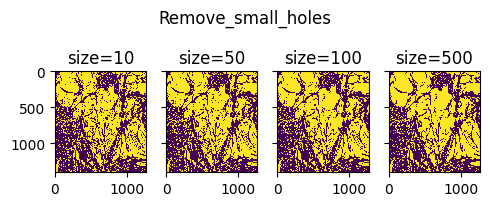

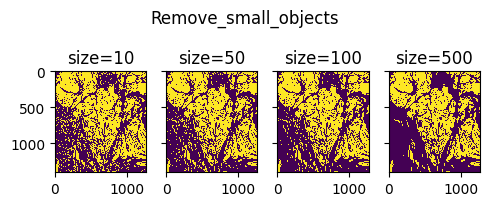

In [28]:
# Question B

from skimage.morphology import remove_small_holes, remove_small_objects

## Remove_small_holes

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(5, 2))
axs = axs.flatten()

for ax, s in zip(axs, [10, 50, 100, 500]): 
    mask_holes = remove_small_holes(mask_thesholding, area_threshold=s)
    ax.imshow(mask_holes, interpolation='nearest')
    ax.title.set_text('size='+str(s))
    
fig.suptitle("Remove_small_holes")
plt.tight_layout()
plt.show()


## Remove_small_objects

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(5, 2))
axs = axs.flatten()

for ax, s in zip(axs, [10, 50, 100, 500]): 
    mask_objects = remove_small_objects(mask_thesholding, min_size=s)
    ax.imshow(mask_objects, interpolation='nearest')
    ax.title.set_text('size='+str(s))
    
fig.suptitle("Remove_small_objects")
plt.tight_layout()
plt.show()

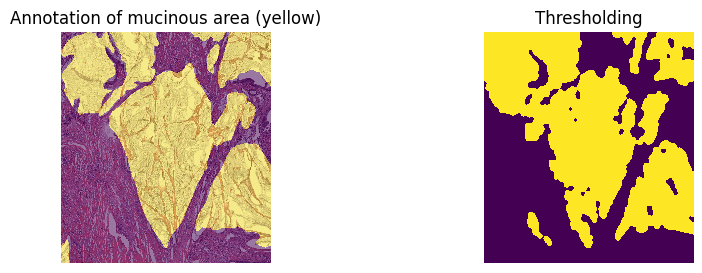

The error is 0.11.


In [29]:
# Question C

fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# Annotated image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[0].set_title('Annotation of mucinous area (yellow)')
ax[0].axis('off')

# Our image

transf1 = closing(mask_thesholding, selem=disk(2))
transf2 = opening(transf1, selem=disk(3))
transf3 = remove_small_holes(transf2, area_threshold=550000)
transf4 = remove_small_objects(transf3, min_size=10000)
transf5 = closing(transf4, selem=disk(10))
transf6 = opening(transf5, selem=disk(15))
mask_morph = transf6

ax[1].imshow(mask_morph, interpolation='nearest')
ax[1].imshow(mask_morph, alpha=0.5, interpolation='nearest')
ax[1].set_title('Thresholding')
ax[1].axis('off')

plt.show()

def error(im, gt):
    I, J = im.shape[0], im.shape[1]
    error = 1 - ((im == gt).sum() / (I*J))
    return error

print('The error is {0:.2f}.'.format(error(mask_morph, adeno_gt)))

---
### 1.4 Region growing (5pts)

In this exercise you will implement from scratch your own region growing algorithm. Choose one of the image channel (R/G/B/H) as the source image. You can use multiple seed point to achieve better results. Plot the best result along with the error rate. Save the mask as the variable `mask_region`.

/var/folders/gl/b2z390zj5hs7g0tkbqqhdg9w0000gn/T/ipykernel_52890/3100226590.py:28: RuntimeWarning: overflow encountered in ubyte_scalars
  if abs(avgs[region][1]-grayImg[neighbour[0], neighbour[1]]) <= maxDeviation:
/var/folders/gl/b2z390zj5hs7g0tkbqqhdg9w0000gn/T/ipykernel_52890/3100226590.py:38: RuntimeWarning: overflow encountered in ubyte_scalars
  region = np.argmin([abs(avgs[0][1]-grayImg[seed[0], seed[1]]), abs(avgs[1][1]-grayImg[seed[0], seed[1]])])


Already 66.16117385476657% treated!
Already 68.96987348336688% treated!
Already 70.95264049263473% treated!
Already 72.41101565975896% treated!
Already 73.1836260151901% treated!
Already 73.80082559513664% treated!
Already 74.53901271690997% treated!
Already 75.13219477925539% treated!
Already 75.58475905705089% treated!
Already 75.96138973118941% treated!
Already 76.28751049711762% treated!
Already 76.64895445052476% treated!
Already 76.93677093194155% treated!
Already 77.14736012608353% treated!
Already 77.44378241591478% treated!
Already 77.7437482739167% treated!
Already 77.96811801094456% treated!
Already 78.15902071524955% treated!
Already 78.38462788878145% treated!
Already 78.56399993475335% treated!
Already 78.74894044499342% treated!
Already 78.92516265259138% treated!
Already 79.05419353169441% treated!
Already 79.24228388030839% treated!
Already 79.39420733473614% treated!
Already 79.58072276416317% treated!
Already 79.75430135741159% treated!
Already 79.86353325244998% tre

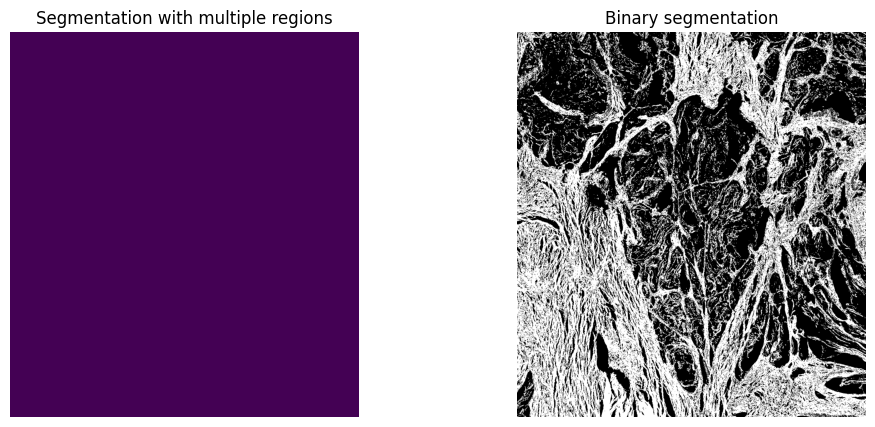

In [19]:
'''
TODO: 
* Binary region growing
'''
import random
import cv2 as cv
from collections import deque

def grow_binary_regions(grayImg, maxDeviation, breakPercentage):
    mask = np.inf*np.ones_like(grayImg)
    dimensions = grayImg.shape
    seed = (random.randint(0,dimensions[0]-1), random.randint(0,dimensions[1]-1))

    point_queue = deque()
    point_queue.append(seed)

    region = 1
    mask[seed[0], seed[1]] = region
    avgs = {1: (1, grayImg[seed[0], seed[1]]), 0: (0,(np.sign(grayImg[seed[0], seed[1]]-0.5)+1)/2)} 
    # Tuples to keep track of average of regions. first element: number of points in region. second element: average of the region
    i = 0
    while np.linalg.norm(mask) == np.inf:
        i += 1
        while len(point_queue) != 0:
            point = point_queue.popleft()
            neighbours = filter(lambda co: (0<=co[0]<dimensions[0]) and (0<=co[1]<dimensions[1]) and (mask[co[0], co[1]] == np.inf),[(point[0]+1,point[1]), (point[0]-1,point[1]), (point[0], point[1]+1), (point[0], point[1]-1)])
            for neighbour in neighbours:
                if abs(avgs[region][1]-grayImg[neighbour[0], neighbour[1]]) <= maxDeviation:
                    point_queue.append(neighbour)
                    mask[neighbour[0], neighbour[1]] = region
                    avgs[region] = (avgs[region][0]+1, (np.prod(avgs[region])+grayImg[neighbour[0], neighbour[1]])/(avgs[region][0]+1))

        seed = (random.randint(0,dimensions[0]-1), random.randint(0,dimensions[1]-1))
        while mask[seed[0], seed[1]] != np.inf:
            seed = (random.randint(0,dimensions[0]-1), random.randint(0,dimensions[1]-1))

        point_queue.append(seed)
        region = np.argmin([abs(avgs[0][1]-grayImg[seed[0], seed[1]]), abs(avgs[1][1]-grayImg[seed[0], seed[1]])])
        mask[seed[0], seed[1]] = region
        avgs[region] = (avgs[region][0]+1, (np.prod(avgs[region])+grayImg[neighbour[0], neighbour[1]])/(avgs[region][0]+1))

        if i%200==0:
            print(f'Already {100*(avgs[0][0]+avgs[1][0])/grayImg.size}% treated!')
        if 100*(avgs[0][0]+avgs[1][0])/grayImg.size>breakPercentage:
            temp = np.vectorize(lambda x: 0 if x==np.inf else x)
            mask = temp(mask)
            break

    return mask

def grow_multiple_regions(grayImg, maxDeviation, startNbSeeds, breakPercentage):
    total_regions = startNbSeeds
    mask = np.zeros_like(grayImg)
    dimensions = grayImg.shape
    seeds = list(zip(random.sample(range(dimensions[0]),startNbSeeds), random.sample(range(dimensions[1]), startNbSeeds)))
    grayValues = dict()
    for regionNb, seed in enumerate(seeds):
        mask[seed[0], seed[1]] = regionNb+1
        grayValues[regionNb+1] = (1, grayImg[seed[0], seed[1]])
    border = seeds
    treated = set(border)
    while len(treated) <= breakPercentage/100*np.prod(dimensions):
        lenTreatedBefore = len(treated)
        nextBorder = []
        for pixel in border:
            regionNb = mask[pixel[0], pixel[1]]
            neighbours = filter(lambda co: (0<=co[0]<dimensions[0]) and (0<=co[1]<dimensions[1]),[(pixel[0]+1,pixel[1]), (pixel[0]-1,pixel[1]), (pixel[0], pixel[1]+1), (pixel[0], pixel[1]-1)])
            regionAvg = grayValues[regionNb][1]
            for neighbour in neighbours:
                if abs(regionAvg-grayImg[neighbour[0], neighbour[1]]) <= maxDeviation:
                    if neighbour in treated:
                        # Merge regions regionNb & mask[neighbour[0], neighbour[1]]
                        regionToMerge = mask[neighbour[0], neighbour[1]]
                        if regionToMerge != regionNb:
                            merge = np.vectorize(lambda x: regionNb if x==regionToMerge else x)
                            mask = merge(mask)
                            grayValues[regionNb] = (grayValues[regionNb][0]+grayValues[regionToMerge][0], (np.prod(grayValues[regionNb]) + np.prod(grayValues[regionToMerge]))/(grayValues[regionNb][0]+grayValues[regionToMerge][0]))
                            del grayValues[regionToMerge]
                    else:
                        mask[neighbour[0], neighbour[1]] = regionNb
                        nextBorder.append((neighbour[0], neighbour[1]))
                        treated.add((neighbour[0], neighbour[1]))
                        grayValues[regionNb] = (grayValues[regionNb][0]+1, (np.prod(grayValues[regionNb])+grayImg[neighbour[0], neighbour[1]])/(grayValues[regionNb][0]+1))

        if len(treated) == lenTreatedBefore:
            # Add new seed
            newSeed = (random.randint(0,dimensions[0]-1), random.randint(0,dimensions[1]-1))
            while newSeed in treated:
                newSeed = (random.randint(0,dimensions[0]-1), random.randint(0,dimensions[1]-1))
            nextBorder.append(newSeed)
            treated.add(newSeed)
            total_regions += 1
            mask[newSeed[0],newSeed[1]] = total_regions
            grayValues[total_regions] = (1,grayImg[newSeed[0], newSeed[1]])
            print('New seed generated! Fraction already assigned: {}'.format(len(treated)/np.prod(dimensions)))

        border = nextBorder
    nbRegions = len(grayValues.keys())
    return mask, nbRegions

def grow_multiple_regions2(grayImg, maxDeviation, startNbSeeds, breakPercentage):
    total_regions = startNbSeeds
    mask = np.inf*np.ones_like(grayImg)
    dimensions = grayImg.shape
    seeds = list(zip(random.sample(range(dimensions[0]),startNbSeeds), random.sample(range(dimensions[1]), startNbSeeds)))
    grayValues = dict()
    points_queue = deque()
    for regionNb, seed in enumerate(seeds):
        mask[seed[0], seed[1]] = regionNb+1
        grayValues[regionNb+1] = (1, grayImg[seed[0], seed[1]])
        points_queue.append(seed)
    while np.sum([a[1] for a in grayValues.values()]) <= breakPercentage/100*np.prod(dimensions):
        while len(points_queue) != 0:
            pixel = points_queue.popleft()
            regionNb = mask[pixel[0], pixel[1]]
            neighbours = filter(lambda co: (0<=co[0]<dimensions[0]) and (0<=co[1]<dimensions[1]),[(pixel[0]+1,pixel[1]), (pixel[0]-1,pixel[1]), (pixel[0], pixel[1]+1), (pixel[0], pixel[1]-1)])
            regionAvg = grayValues[regionNb][1]
            for neighbour in neighbours:
                if abs(regionAvg-grayImg[neighbour[0], neighbour[1]]) <= maxDeviation:
                    if (mask[neighbour[0], neighbour[1]] != np.inf) and (mask[neighbour[0], neighbour[1]] != regionNb):
                        regionToMerge = mask[neighbour[0], neighbour[1]]
                        merge = np.vectorize(lambda x: regionNb if x==regionToMerge else x)
                        mask = merge(mask)
                        grayValues[regionNb] = (grayValues[regionNb][0]+grayValues[regionToMerge][0], (np.prod(grayValues[regionNb]) + np.prod(grayValues[regionToMerge]))/(grayValues[regionNb][0]+grayValues[regionToMerge][0]))
                        del grayValues[regionToMerge]
                    else:
                        mask[neighbour[0], neighbour[1]] = regionNb
                        points_queue.append((neighbour[0], neighbour[1]))
                        grayValues[regionNb] = (grayValues[regionNb][0]+1, (np.prod(grayValues[regionNb])+grayImg[neighbour[0], neighbour[1]])/(grayValues[regionNb][0]+1))

        # Add new seed
        newSeed = (random.randint(0,dimensions[0]-1), random.randint(0,dimensions[1]-1))
        while mask[newSeed[0], newSeed[1]] != np.inf:
            newSeed = (random.randint(0,dimensions[0]-1), random.randint(0,dimensions[1]-1))
        points_queue.append(newSeed)
        total_regions += 1
        mask[newSeed[0],newSeed[1]] = total_regions
        grayValues[total_regions] = (1,grayImg[newSeed[0], newSeed[1]])
        print('New seed generated! Fraction already assigned: {}'.format(np.sum([a[1] for a in grayValues.values()])*100/np.prod(dimensions)))

    nbRegions = len(grayValues.keys())
    return mask, nbRegions

grayImg = cv.cvtColor(adeno_img, cv.COLOR_RGB2GRAY)

maskBinary = grow_binary_regions(grayImg, 40, 90)
maskBinary = 255*maskBinary

# maskMultiRegion, nbRegions = grow_multiple_regions2(grayImg, 40, 3, 30)
# maskMultiRegion = np.floor(255/nbRegions*maskMultiRegion)
# print('Number of regions with multiRegion: {}'.format(nbRegions))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Plot image
ax[0].imshow(np.zeros_like(maskBinary))
ax[0].set_title('Segmentation with multiple regions')
ax[0].axis('off')

ax[1].imshow(maskBinary, cmap='gray')
ax[1].set_title('Binary segmentation')
ax[1].axis('off')

plt.show()

---
### 1.5 Method comparison (1pt)

In this section we display the overall outputs. Please make sure that you create the variables `mask_thesholding`, `mask_morph`, and `mask_region` to properly display the output. Comment on the results and what you think would be the best approach.

In [20]:
# Add your comments here
mask_region = maskBinary

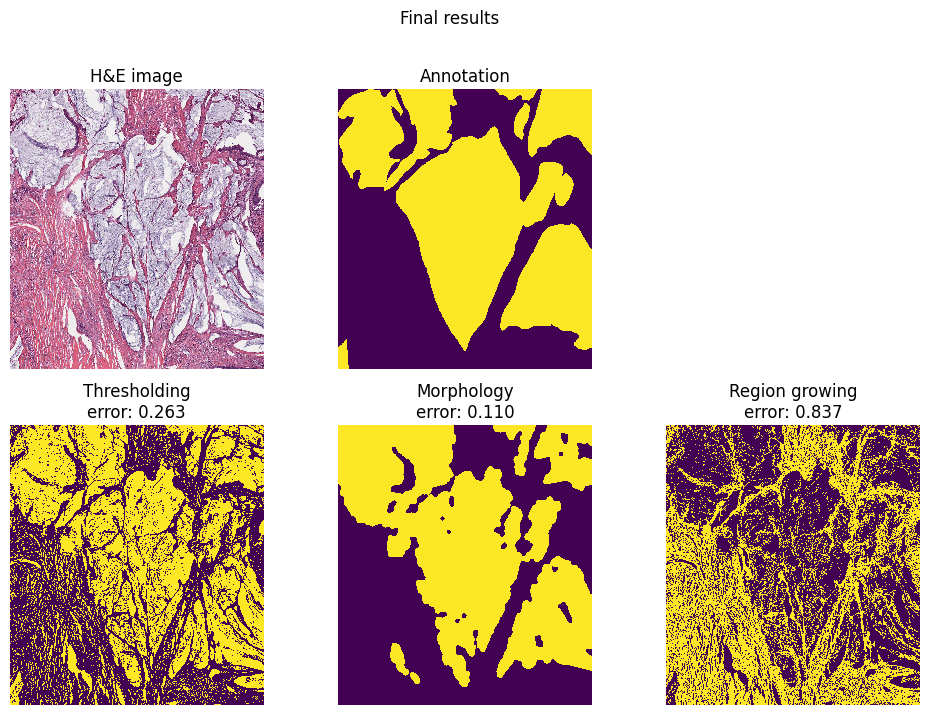

In [30]:
error_th = 1- (mask_thesholding == adeno_gt).mean()
error_morph = 1- (mask_morph == adeno_gt).mean()
error_region = 1- (mask_region == adeno_gt).mean()


# Display MRI image
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Plot image
ax[0, 0].imshow(adeno_img, interpolation='nearest')
ax[0, 0].set_title('H&E image'.format(im_h, im_w))

# Plot image with overlay
ax[0, 1].imshow(adeno_gt, interpolation='nearest')
ax[0, 1].set_title('Annotation')

# Plot estimation using thresholding
ax[1, 0].imshow(mask_thesholding, interpolation='nearest')
ax[1, 0].set_title('Thresholding\nerror: {:.3f}'.format(error_th))

# Plot estimation using Contour detection
ax[1, 1].imshow(mask_morph, interpolation='nearest')
ax[1, 1].set_title('Morphology\nerror: {:.3f}'.format(error_morph))


# Plot estimation using Region growing
ax[1, 2].imshow(mask_region, interpolation='nearest')
ax[1, 2].set_title('Region growing\nerror: {:.3f}'.format(error_region))


[a.axis('off') for a in ax.ravel()]


plt.suptitle("Final results")
plt.show()

# ---
## Part 2: Axon segmentations (10 points)

#### Intro 

Axon segmentation is vital to neuroscience research as it enables the study of neurons' morphology and connectivity. We will conduct two exercises to evaluate the impact of your segmentation algorithms under different independent artefacts. Each exercise consists of a synthetic **Ground Truth (GT)** and two more images simulating a specific artifact.

The **Ground Truth**  has tree main compartments. 1) The inner part of the axon. 2) The outer layer of the axon (called myelin) and the extracellular slace (the background of the image). 

The task consists into segmenting the three main compartments in the image to compute the inner-axon and outer-axon radii distribution.


To compute the radii, we suggest the following approximation.
$$\hat{r}_{I}= \sqrt{\frac{A_{yellow}}{\pi}}$$
$$\hat{r}_{O}= \sqrt{\frac{A_{yellow} + A_{blue}}{\pi}}$$
Where **A** is the corresponding area of the comparments. 
**Using this image as reference** 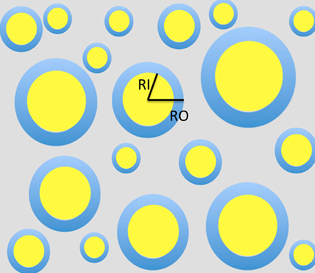

#### Artifacts simulated:

Excercise 1) Two images with different levels of SNR (signal to noise ratio). The images have rician noise.
Exercise  2) Two images adquired using a fraction of the fourier space. Only Lowest frequency are used to reconstruct the image. (simulating fast aquisitions in MRI)

Ensure your algorithm works on the GT before you go to the test cases with artifacts. Apply any preprocessing needed to the image. The preprocessing can be different for each type of image.

### Tasks

For each exercise we ask to:

1) Segment the images with the following colors: blue the inner part of the axon, red the outer part of the axon (myelin) and white for the backround(example) 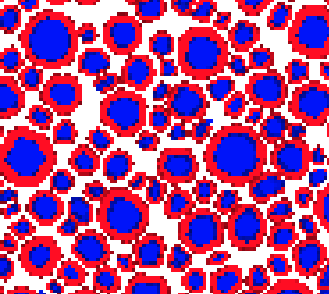

2) Count the number of axons obtained in the sample, calculate the radii for each axons, and display a radii histogram for the each of the images(GT and test cases).

In the exercises, assume that each pixel side is $(0.1 \mu m)$, i.e. a pixel has an area of $(0.01 \mu m^2 )$

## Grading 
The answers does not have to be perfect, they just be a good approximation.

1. Developing an algorithm that works for the two GT images. **(3 points)** 
2. Use preprosesing to prepare the images with SNR and the Low frequencies.  (**1 point** for SNR preprocesing , **1 point** for Low-frequency images preprocesing)
3. Running the algorithm in the test images. **1/2 point** SNR, **1/2 point** Low freqs
4. Computing and plotting radii distributions **(1 point)**
5. Explaining and discussing your implementation. **(3 points )**
    Try to be specific, not necessarily long. In the discussion include:
 1. What worked? 
 2. What did not work?
 3. Why do you think it does not work? 
 4. How could you improve your algorithms as future work?  Try to avoid general comments like "using deep learning" 
 
**Extra points: Real data example (3 points), the algorithm should display a _good enough_ segmentation.**

### 2.1 SNR

In [ ]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np

data_base_path = os.path.join('../data') # os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'

path_folder = os.path.join(data_base_path, data_folder) + '/' 

print(path_folder)

files = ["GT_0.png"  , "test_0_0.png" , "test_0_1.png"]
gt_0 = cv.imread(path_folder+ files[0])
snr_10 = cv.imread(path_folder+ files[1])
snr_3 = cv.imread(path_folder+ files[2])

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.1.1 Preprocessing 

 % add your images after preprocessing


In [ ]:
from skimage import color
from skimage.filters import median
from skimage.morphology import disk

#Switch to greyscale image and check result:
images_gray=images.copy()
for i,im in enumerate(images):
    images_gray[i] = color.rgb2gray(im)

# Apply a median filter to remove noise
images_wo_noise = images_gray.copy()

images_wo_noise[0] = images_gray[0]
images_wo_noise[1] = median(images_gray[1], disk(1))
images_wo_noise[2] = median(images_gray[2], disk(2))

fig, axes = plt.subplots(1, 3, figsize=(15, 7))
for ax, im, nm in zip(axes.ravel(), images_wo_noise, im_names):
    ax.imshow(im[0:512,0:512],cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [ ]:
# Display histogram

fig, axs = plt.subplots(1, 3, sharey=False, figsize=(15, 6))
axs = axs.flatten()

for ax, im, nm in zip(axs, images_wo_noise, im_names):
    ax.hist(im.ravel(), bins=200)
    ax.title.set_text(nm)
    ax.set_xlabel('Pixel intensity')
    ax.set_ylabel('Number of pixels')
    
fig.suptitle("Histogram for images_wo_noise")
plt.tight_layout()
plt.show()


### 2.1.2 Results Segmetations

In [ ]:
from skimage.filters import threshold_multiotsu

images_th = images_wo_noise.copy()
th = []

# Thresholding
for i, im in enumerate(images_wo_noise):
    # Applying multi-Otsu threshold for the default value, generating three classes
    th.append(threshold_multiotsu(im,3,300)) 
    # Using the threshold values, we generate the three regions
    images_th[i] = np.digitize(im, bins=th[i])


# Plotting results of segmentation
palette = np.array([[255,   0,   0],   # red
                    [  0,   0, 255],   # blue
                    [255, 255, 255]])  # white

images_RBW = [palette[images_th[0]],palette[images_th[1]] ,palette[images_th[2]]] #Image in Red Blue White

im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for ax, im, nm in zip(axes.ravel(), images_RBW, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
fig.suptitle("Segmentation")
plt.tight_layout()
plt.show()


# Plotting the histogram and the two thresholds obtained from multi-Otsu on images_wo_noise
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for ax, im, nm, i in zip(axes.ravel(), images_wo_noise, im_names, [0,1,2]):
    ax.hist(im.ravel(), bins=100)
    ax.set_title(nm)
    for thresh in th[i]:
        ax.axvline(thresh, color='r')
fig.suptitle("Thresholds applied on histograms of images_wo_noise")
plt.tight_layout()
plt.show()    


# Plotting the histogram of images_th
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for ax, im, nm, i in zip(axes.ravel(), images_th, im_names, [0,1,2]):
    ax.hist(im.ravel(), bins=100)
    ax.set_title(nm)
fig.suptitle("Histograms of thresholded images")
plt.tight_layout()
plt.show() 

### 2.1.3 Radii histrograms 

In [ ]:
def radii(th_im):
    # Convert image to 8 bit and binary for inner and outer areas of the objects
    th_im8_i = cv.convertScaleAbs(np.where(th_im==1, 255, 0))
    th_im8_o = cv.convertScaleAbs(np.where(th_im==0, 255, 0))
    
    # Detect inner and outer contours
    Cs_i, _ = cv.findContours(th_im8_i, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    Cs_o, _ = cv.findContours(th_im8_o, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    # Calculate area for each object
    Rs_i = np.empty(0)
    Rs_o = np.empty(0)
    for C_i, C_o in zip(Cs_i, Cs_o):
        A_i = cv.contourArea(C_i)
        A_o = cv.contourArea(C_o)
        R_i = np.sqrt(A_i/np.pi)
        R_o = np.sqrt((A_i+A_o)/np.pi)
        Rs_i=np.append(Rs_i,np.array([R_i]),axis=0)
        Rs_o=np.append(Rs_o,np.array([R_o]),axis=0)
    
    return cv.cvtColor(th_im8_i, cv.COLOR_GRAY2BGR), cv.cvtColor(th_im8_o, cv.COLOR_GRAY2BGR), Cs_i, Cs_o, Rs_i, Rs_o


# Apply radii to each image, get all radii and check contours

fig, axes = plt.subplots(3, 2, figsize=(22, 20))
all_rads = []

for ax, im, nm in zip([0, 1, 2], images_th, im_names):
    
    th_im8_i, th_im8_o, Cs_i, Cs_o, Rs_i, Rs_o = radii(im)
    
    all_rads.append([Rs_i, Rs_o])
        
    axes[ax,0].imshow(cv.drawContours(th_im8_i, Cs_i, -1, (0, 255, 0), 1))
    axes[ax,0].axis('off')
    axes[ax,0].set_title(nm+': inner')
    
    axes[ax,1].imshow(cv.drawContours(th_im8_o, Cs_o, -1, (255, 0, 0), 1))
    axes[ax,1].axis('off')
    axes[ax,1].set_title(nm+': outer')

fig.suptitle("Contours")
plt.tight_layout()
plt.show()

In [ ]:
# # More check...
# th_im8_i, th_im8_o, Cs_i, Cs_o, Rs_i, Rs_o = radii(images_th[1])

# plt.figure(figsize=(30,30))
# plt.imshow(cv.drawContours(th_im8_i, Cs_i, -1, (0, 255, 0), 1))
# plt.show()

# plt.figure(figsize=(30,30))
# plt.imshow(cv.drawContours(th_im8_o, Cs_o, -1, (255, 0, 0), 1))
# plt.show()

In [ ]:
# Radii distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0], color="red", label="inner", alpha=0.5)
    ax.hist(rads[1], color="blue", label="outer", alpha=0.5)
    ax.legend()
    ax.set_title(nm)
    
plt.show()

### 2.2 Low frequencies

In [ ]:
import cv2 as cv
import os
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data_base_path = os.path.join('../data') # os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'

path_folder = os.path.join(data_base_path, data_folder) + '/' 

print(path_folder)

files = ["GT_3.png"  , "test_3_0.png" , "test_3_1.png"]
path = "data/"
gt_3 = cv.imread(path_folder+ files[0])
lowfreq0 = cv.imread(path_folder+ files[1])
lowfreq1 = cv.imread(path_folder+ files[2])

images = [gt_3 , lowfreq0, lowfreq1]
im_names = ["GT" , "Low " , "Lower"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2.1 Preprocessing

In [ ]:
from scipy.signal import wiener
from skimage import color

#Switch to greyscale image and check result:
images_gray=images.copy()
for i,im in enumerate(images):
    images_gray[i] = color.rgb2gray(im)

filtered_imgs = images_gray.copy()
filtered_imgs[0] = images_gray[0]
filtered_imgs[1] = wiener(images_gray[1],3)
filtered_imgs[2] = wiener(images_gray[2],5)


fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), filtered_imgs, im_names):
    ax.imshow(im[0:512,0:512],cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images_gray, im_names):
    ax.imshow(im[0:512,0:512],cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [ ]:
# Display histogram

fig, axs = plt.subplots(1, 3, sharey=False, figsize=(15, 6))
axs = axs.flatten()

for ax, im, nm in zip(axs, filtered_imgs, im_names):
    ax.hist(im.ravel(), bins=200)
    ax.title.set_text(nm)
    ax.set_xlabel('Pixel intensity')
    ax.set_ylabel('Number of pixels')
    
fig.suptitle("Histogram for images_wo_noise")
plt.tight_layout()
plt.show()

### 2.2.2 Results Segmetations


### 2.2.3 Radii histrograms

### 2.5 Not mandatory exercise, Real data ( 3 points )

The points are given just by having a good enough segmentation.

In [ ]:
# Add your implementation and discussion
import cv2 as cv

files = ["extra_point.png" ]
real_data = cv.imread(path_folder+ files[0])

plt.imshow(real_data[:256, :256])